In [1]:
##denpendents 
import os
import shutil
import random

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy

In [7]:
##folder structures and directory
RAW_DIR = "data/raw"
OUT_DIR = "data"
BAD_DIR = "data/corrupt"

##image resize process
IMG_HEIGHT=180    ##Resize all images
IMG_WIDTH=180   ##Resize all images
CHANNELS=3
BATCH_SIZE=32 
EPOCHS=10

##splitting ratio
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

##Reproducibility
SEED = 42
random.seed(SEED)

In [67]:
##cleaning data
def clean_corrupt_dataset_checker(image_dir, bad_dir):
    # Create the folder where corrupted images will be stored.
    os.makedirs(bad_dir, exist_ok=True)

    # Walk through all directories and files inside image_dir.(Walking through the dataset)
    # os.walk returns:
    #   root  -> current folder path
    #   dirs  -> list of subfolders inside root
    #   files -> list of files inside root
    for root, dirs, files in os.walk(image_dir):

        # Loop through every file found in the current folder
        for file in files:

            # Process only image files with these extensions
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):

                # Build the full path to the current image file
                src_path = os.path.join(root, file)

                # Start by assuming the image is clean
                corrupted = False

                # ----------------------------------------------------
                # Pillow validation (two-step check)
                # ----------------------------------------------------
                try:
                    # First check: verify the image header structure
                    with Image.open(src_path) as img:
                        '''
                        The file type (JPEG, PNG, etc.)
                        The image width and height
                        The color mode (RGB, grayscale, etc.)
                        Compression details
                        Metadata markers
                        '''
                        img.verify()

                    # Second check: fully load the image pixel data
                    with Image.open(src_path) as img:
                        img.load()

                except Exception:
                    # If Pillow fails at any point, mark as corrupted
                    corrupted = True

                # TensorFlow validation (strict decoder)
                # ----------------------------------------------------
                if not corrupted:  # Only check if Pillow passed
                    try:
                        '''
                        Pillow checks:
                                To catch header issues and partial corruption.
                        TensorFlow checks:
                                To catch strict JPEG/PNG decoding errors that Pillow misses.
                        '''
                        # Read the image file as raw bytes
                        #TensorFlow can only decode images from raw bytes, not from a Pillow image object or a file path.
                        img_bytes = tf.io.read_file(src_path)

                        # Try decoding it using TensorFlow's strict decoder which make images compatible with tensorflow
                        #If decoding succeeds → the image is clean.
                        #If decoding fails → the image is corrupted.
                        img1=tf.image.decode_jpeg(img_bytes, channels=3)

                        # FORCE resize (this catches hidden corruption)
                        img2 = tf.image.resize(img1, (IMG_HEIGHT, IMG_WIDTH))

                        # Force full materialization
                        img = tf.cast(img2, tf.uint8)

                    except Exception:
                        # If TensorFlow fails, the image is corrupted
                        corrupted = True

                    # Move the file to the appropriate folder
                    # ----------------------------------------------------
                    if corrupted:
                        # Move corrupted image to bad_dir
                        shutil.move(src_path, os.path.join(bad_dir, file))

In [68]:
##move the corrupted files
clean_corrupt_dataset_checker(RAW_DIR,BAD_DIR)

## Data Loading using Tensorflow

In [69]:
##data loading 
raw_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    RAW_DIR,
    shuffle=True,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 25218 files belonging to 22 classes.


In [70]:
##class name
class_name=raw_dataset.class_names
len(class_name)
class_name

['Cashew anthracnose',
 'Cashew gumosis',
 'Cashew healthy',
 'Cashew leaf miner',
 'Cashew red rust',
 'Cassava bacterial blight',
 'Cassava brown spot',
 'Cassava green mite',
 'Cassava healthy',
 'Cassava mosaic',
 'Maize fall armyworm',
 'Maize grasshoper',
 'Maize healthy',
 'Maize leaf beetle',
 'Maize leaf blight',
 'Maize leaf spot',
 'Maize streak virus',
 'Tomato healthy',
 'Tomato leaf blight',
 'Tomato leaf curl',
 'Tomato septoria leaf spot',
 'Tomato verticulium wilt']

<h2 style='text-align:center; font-family:Geogeria; color:white'><b>Data Preprocessing: Way of Splitting data</b></h2>

In [71]:
len(raw_dataset)*TRAIN_RATIO

552.3

In [72]:
train=raw_dataset.take(550)
len(train)

550

In [73]:
rest_data=raw_dataset.skip(550)
len(rest_data)

239

In [74]:
len(raw_dataset)*VAL_RATIO

118.35

In [75]:
len(raw_dataset)*TEST_RATIO

118.35

In [76]:
test=rest_data.take(118)
len(test)

118

In [77]:
val=rest_data.skip(118)
len(val)

121

In [78]:
##user define function to perform data spliting
def train_test_partition(data, train_split=0.80, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=100):
   total_data= len(data)

   if shuffle:
      data = data.shuffle(shuffle_size, SEED)
    
   ## train, test, validation size based on the given data and splitting size
   train_size=int(total_data*train_split)
   val_size=int(total_data*val_split)
   
   ##splitted data
   train_set=data.take(train_size)
   val_set=data.skip(train_size).take(val_size)
   test_set=data.skip(train_size).skip(val_size)

   ## return the train, test and validation set
   return train_set, test_set, val_set

In [79]:
##calling the function to extract train, test, validation data 
train_data, test_data, val_data = train_test_partition(raw_dataset)

In [80]:
##checking 
len(train_data)

631

<h2 style='text-align:center; font-family:Geogeria; color:white'><b>Display Images</b></h2>

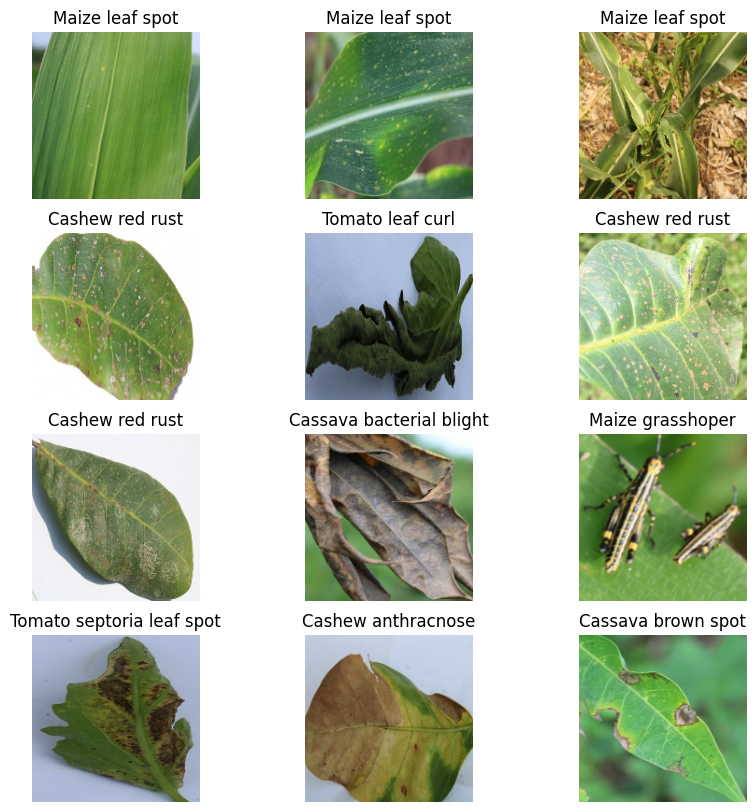

In [95]:
##print images from the train dataset
## taking 1st batch only take(1)

plt.figure(figsize=(10,10))
for image,labels in raw_dataset.take(1):
    for i in range(12):
        ax=plt.subplot(4,3,i+1)
        plt.imshow(np.array(image[i]).astype('uint8'))
        plt.title(class_name[labels[i]])
        plt.axis("off")
plt.show()

In [96]:
## number of class
##class name
class_name=raw_dataset.class_names
n_classes=len(class_name)

In [97]:
# train_ds.cardinality().numpy()

In [98]:
## model building
##image input size
input_shapes=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS)

##my model architecture
model= Sequential([
    ##image resizing
    layers.Resizing(IMG_HEIGHT,IMG_WIDTH),
    ##normalisation layer
    layers.Rescaling(1./255),
    ##randomly flip the images
    layers.RandomFlip("horizontal_and_vertical"),
    ##random rotation
    layers.RandomRotation(0.2),

    ##first convolutional layer
    layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=input_shapes),
    ##pooling layer
    layers.MaxPooling2D(),
    ##2nd convolutional layer
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    ##3rd convolutional layer
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    ##convert into a vector
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    ##output layer
    layers.Dense(n_classes, activation='softmax')
])

#the model parameters, use the .build() method to see trainable parameters before compiling it with optimizers 
# otherwise it won't be needed
model.build(input_shape=input_shapes)

In [99]:
##helps to check trainable parameter
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (32, 180, 180, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 180, 180, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 90, 90, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 90, 90, 64)       │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 45, 45, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 45, 45, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 61952)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 22)               │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,016,406 (30.58 MB)

 Trainable params: 8,016,406 (30.58 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
##compile the model with optimizers
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [101]:
##training the model
History=model.fit(train_data,
          epochs=EPOCHS,
          verbose=1,
          batch_size=BATCH_SIZE,
          validation_data=val_data)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_460779]

Corrupt JPEG data: 28240 extraneous bytes before marker 0xd9
JPEG datastream contains no image
